# Model-2: Denoising Autoencoder (DAE)

### Part 1:

A Denoising Autoencoder (DAE) is trained to reconstruct original images from corrupted
versions.
● Apply Gaussian noise (mean=0, variance=0.1) to input images before feeding them into
the encoder.
● The architecture remains the same as AE, but the model learns to remove noise instead
of just reconstructing inputs.
Task:
1. Train the DAE with different levels of noise (e.g., Gaussian noise with σ = 0.1, 0.3,
0.5).
2. Compare the reconstruction quality of DAE vs. AE on clean vs. noisy inputs.
3. Evaluate denoising performance by testing on unseen noisy images.
Presentation of Results:
● Visualize original, noisy, and reconstructed images.
● Plot the average error vs. epochs for both AE and DAE.
● Compare feature extraction quality between AE and DAE using a classifier trained
on their latent representations.
● Discuss when AE vs. DAE is preferable for feature learning.

In [2]:
import torch

# Check if CUDA (GPU) is available
print("CUDA Available:", torch.cuda.is_available())

# If available, print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [1]:
# ----------------------
# Imports & Setup
# ----------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# ----------------------
# Data Loading with Noise Injection
# ----------------------

def add_gaussian_noise(img, mean=0., std=0.1):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [5]:
# ----------------------
# Denoising Autoencoder Architecture
# ----------------------
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 4x4
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1),  # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),   # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, output_padding=1, padding=1),    # 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

model = DenoisingAutoencoder().to(device)

In [6]:
# ----------------------
# Training Function
# ----------------------
def train_dae(model, noise_std, num_epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_errors = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, _ in trainloader:
            inputs = inputs.to(device)
            noisy_inputs = add_gaussian_noise(inputs, std=noise_std).to(device)

            outputs, _ = model(noisy_inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)

        avg_loss = epoch_loss / len(trainloader.dataset)
        train_errors.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return train_errors

In [7]:
# ----------------------
# Train DAE with Different Noise Levels
# ----------------------
noise_levels = [0.1, 0.3, 0.5]
all_errors = {}

for noise_std in noise_levels:
    print(f"\nTraining DAE with Gaussian noise std = {noise_std}")
    model = DenoisingAutoencoder().to(device)
    errors = train_dae(model, noise_std=noise_std, num_epochs=20)
    all_errors[noise_std] = errors


Training DAE with Gaussian noise std = 0.1
Epoch [1/20], Loss: 0.0175
Epoch [2/20], Loss: 0.0078
Epoch [3/20], Loss: 0.0060
Epoch [4/20], Loss: 0.0053
Epoch [5/20], Loss: 0.0046
Epoch [6/20], Loss: 0.0042
Epoch [7/20], Loss: 0.0039
Epoch [8/20], Loss: 0.0037
Epoch [9/20], Loss: 0.0036
Epoch [10/20], Loss: 0.0034
Epoch [11/20], Loss: 0.0033
Epoch [12/20], Loss: 0.0032
Epoch [13/20], Loss: 0.0031
Epoch [14/20], Loss: 0.0030
Epoch [15/20], Loss: 0.0029
Epoch [16/20], Loss: 0.0029
Epoch [17/20], Loss: 0.0028
Epoch [18/20], Loss: 0.0028
Epoch [19/20], Loss: 0.0027
Epoch [20/20], Loss: 0.0027

Training DAE with Gaussian noise std = 0.3
Epoch [1/20], Loss: 0.0195
Epoch [2/20], Loss: 0.0103
Epoch [3/20], Loss: 0.0091
Epoch [4/20], Loss: 0.0085
Epoch [5/20], Loss: 0.0082
Epoch [6/20], Loss: 0.0079
Epoch [7/20], Loss: 0.0075
Epoch [8/20], Loss: 0.0073
Epoch [9/20], Loss: 0.0072
Epoch [10/20], Loss: 0.0071
Epoch [11/20], Loss: 0.0070
Epoch [12/20], Loss: 0.0069
Epoch [13/20], Loss: 0.0068
Epoch 

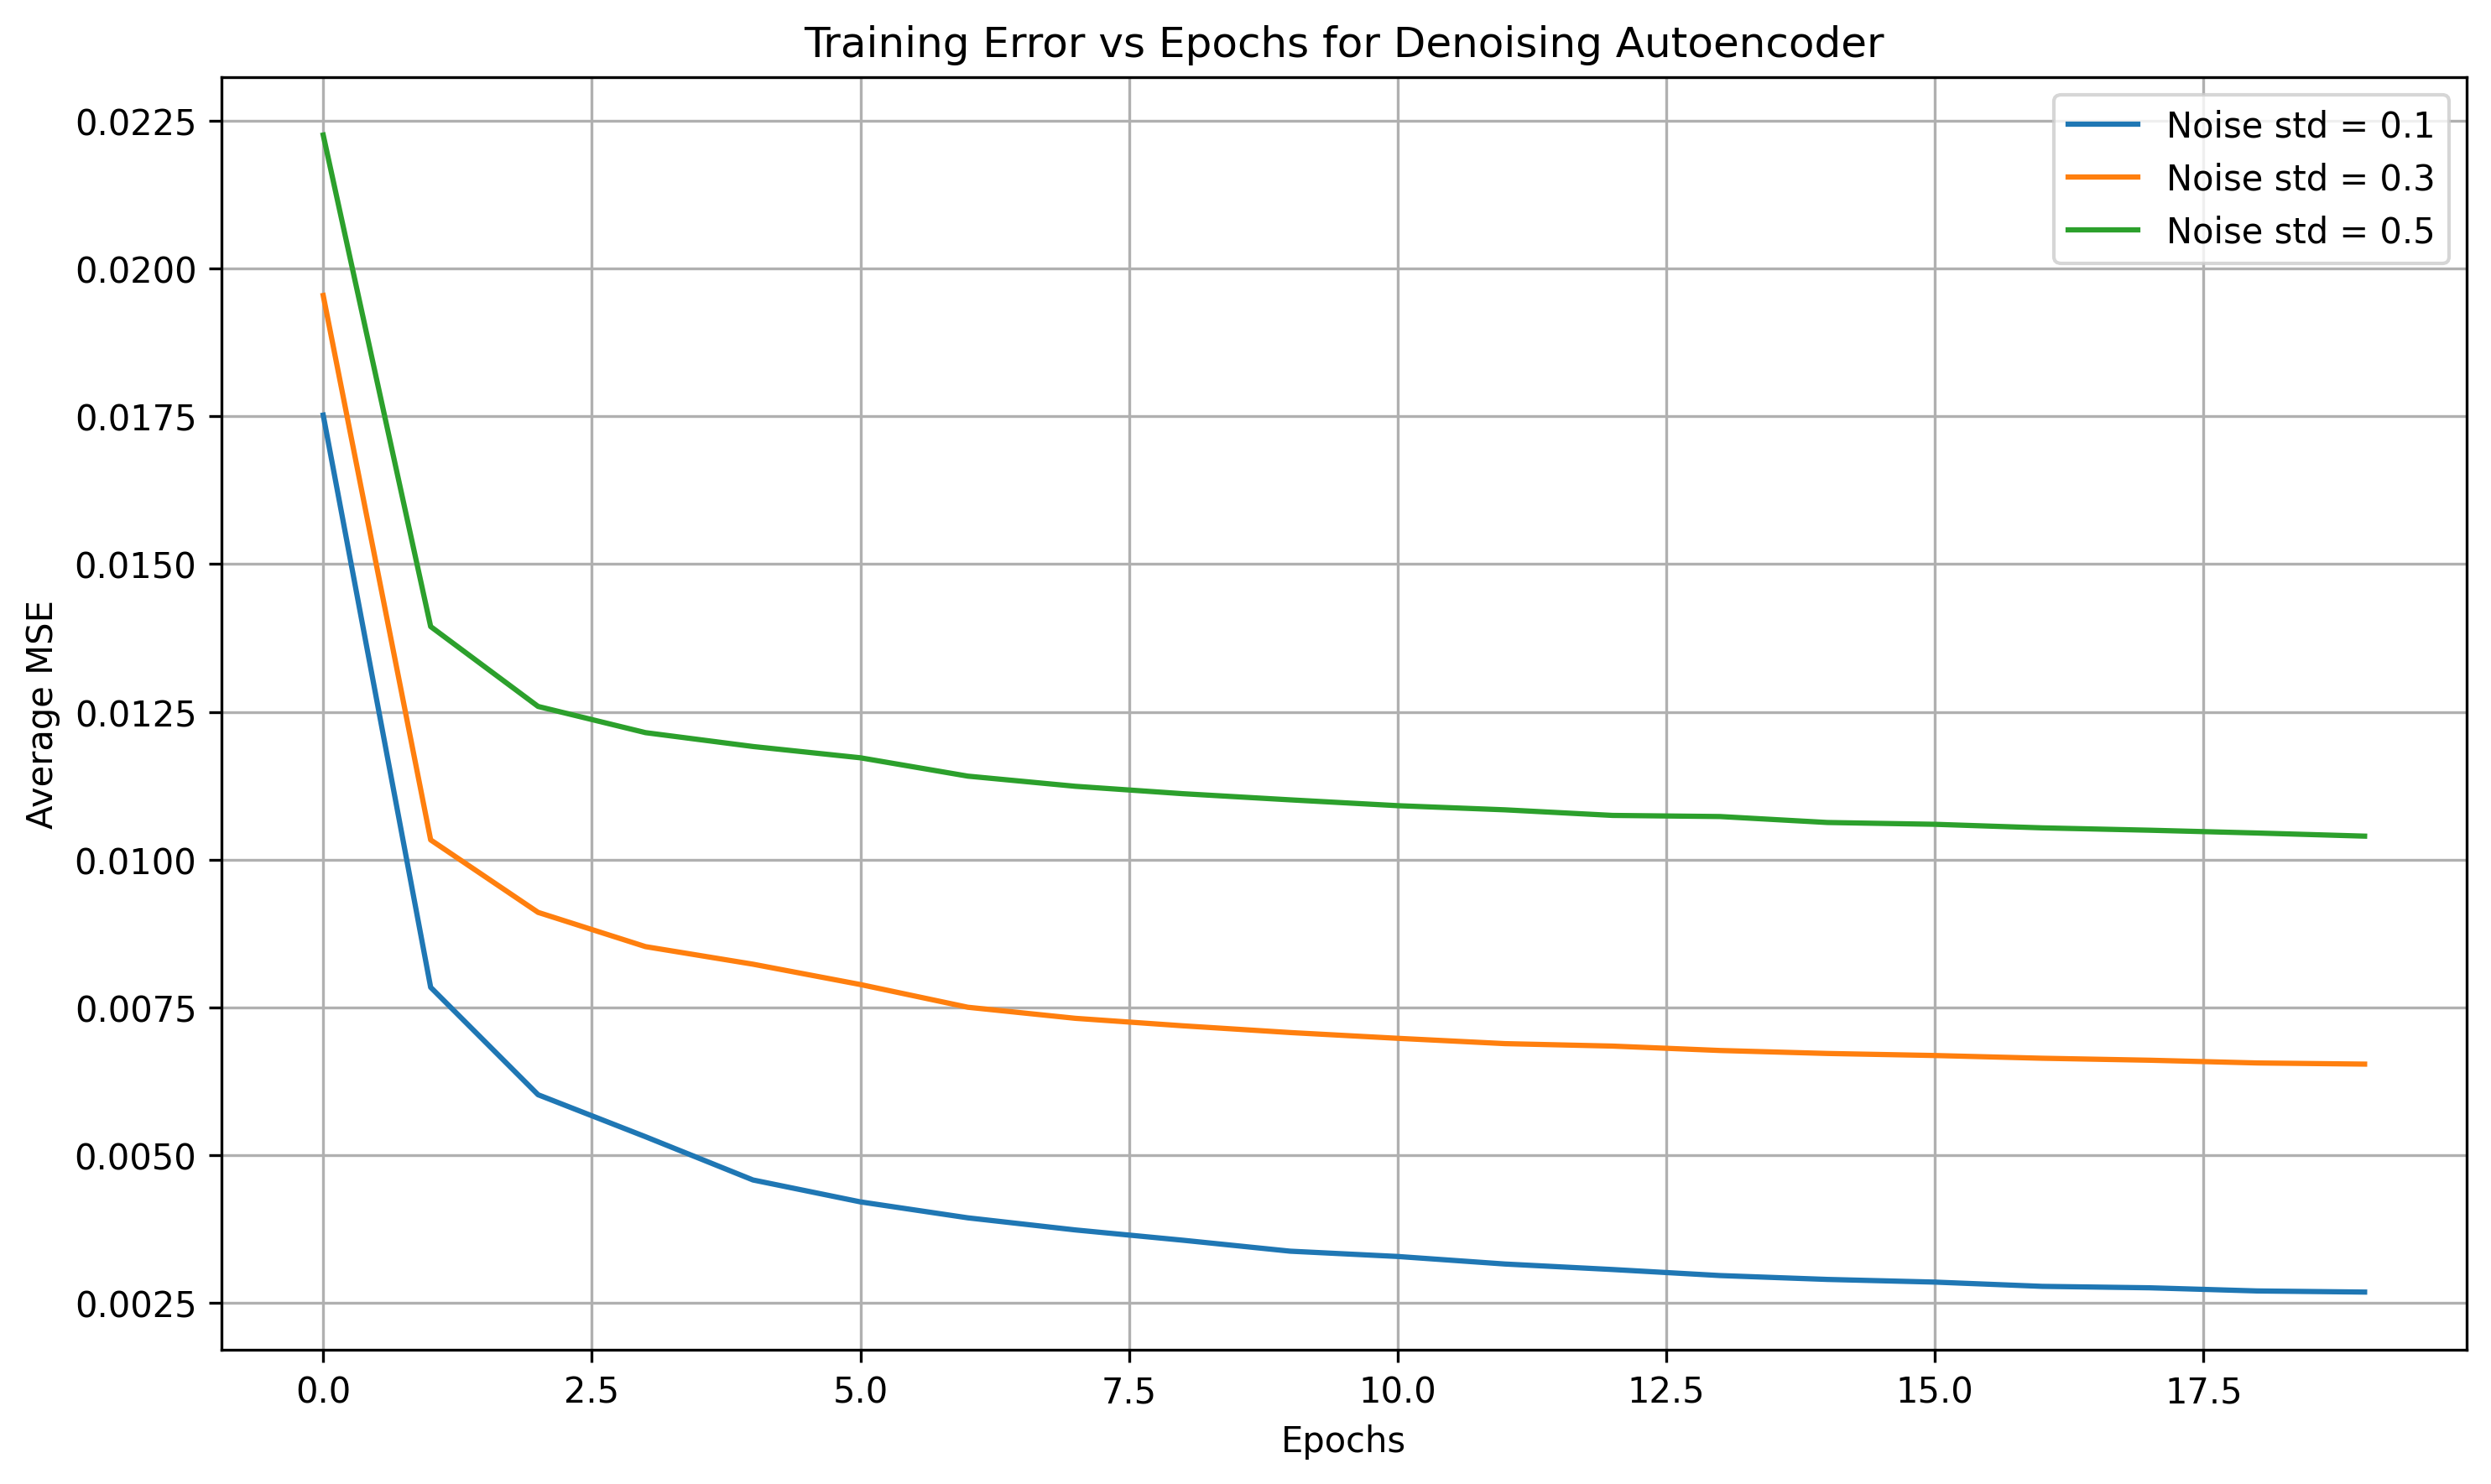

In [8]:
# ----------------------
# Plot Errors
# ----------------------
plt.figure(figsize=(10,6), dpi=300)
for noise_std, errors in all_errors.items():
    plt.plot(errors, label=f"Noise std = {noise_std}")

plt.xlabel("Epochs")
plt.ylabel("Average MSE")
plt.title("Training Error vs Epochs for Denoising Autoencoder")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("dae_training_error.png", dpi=300)
plt.show()


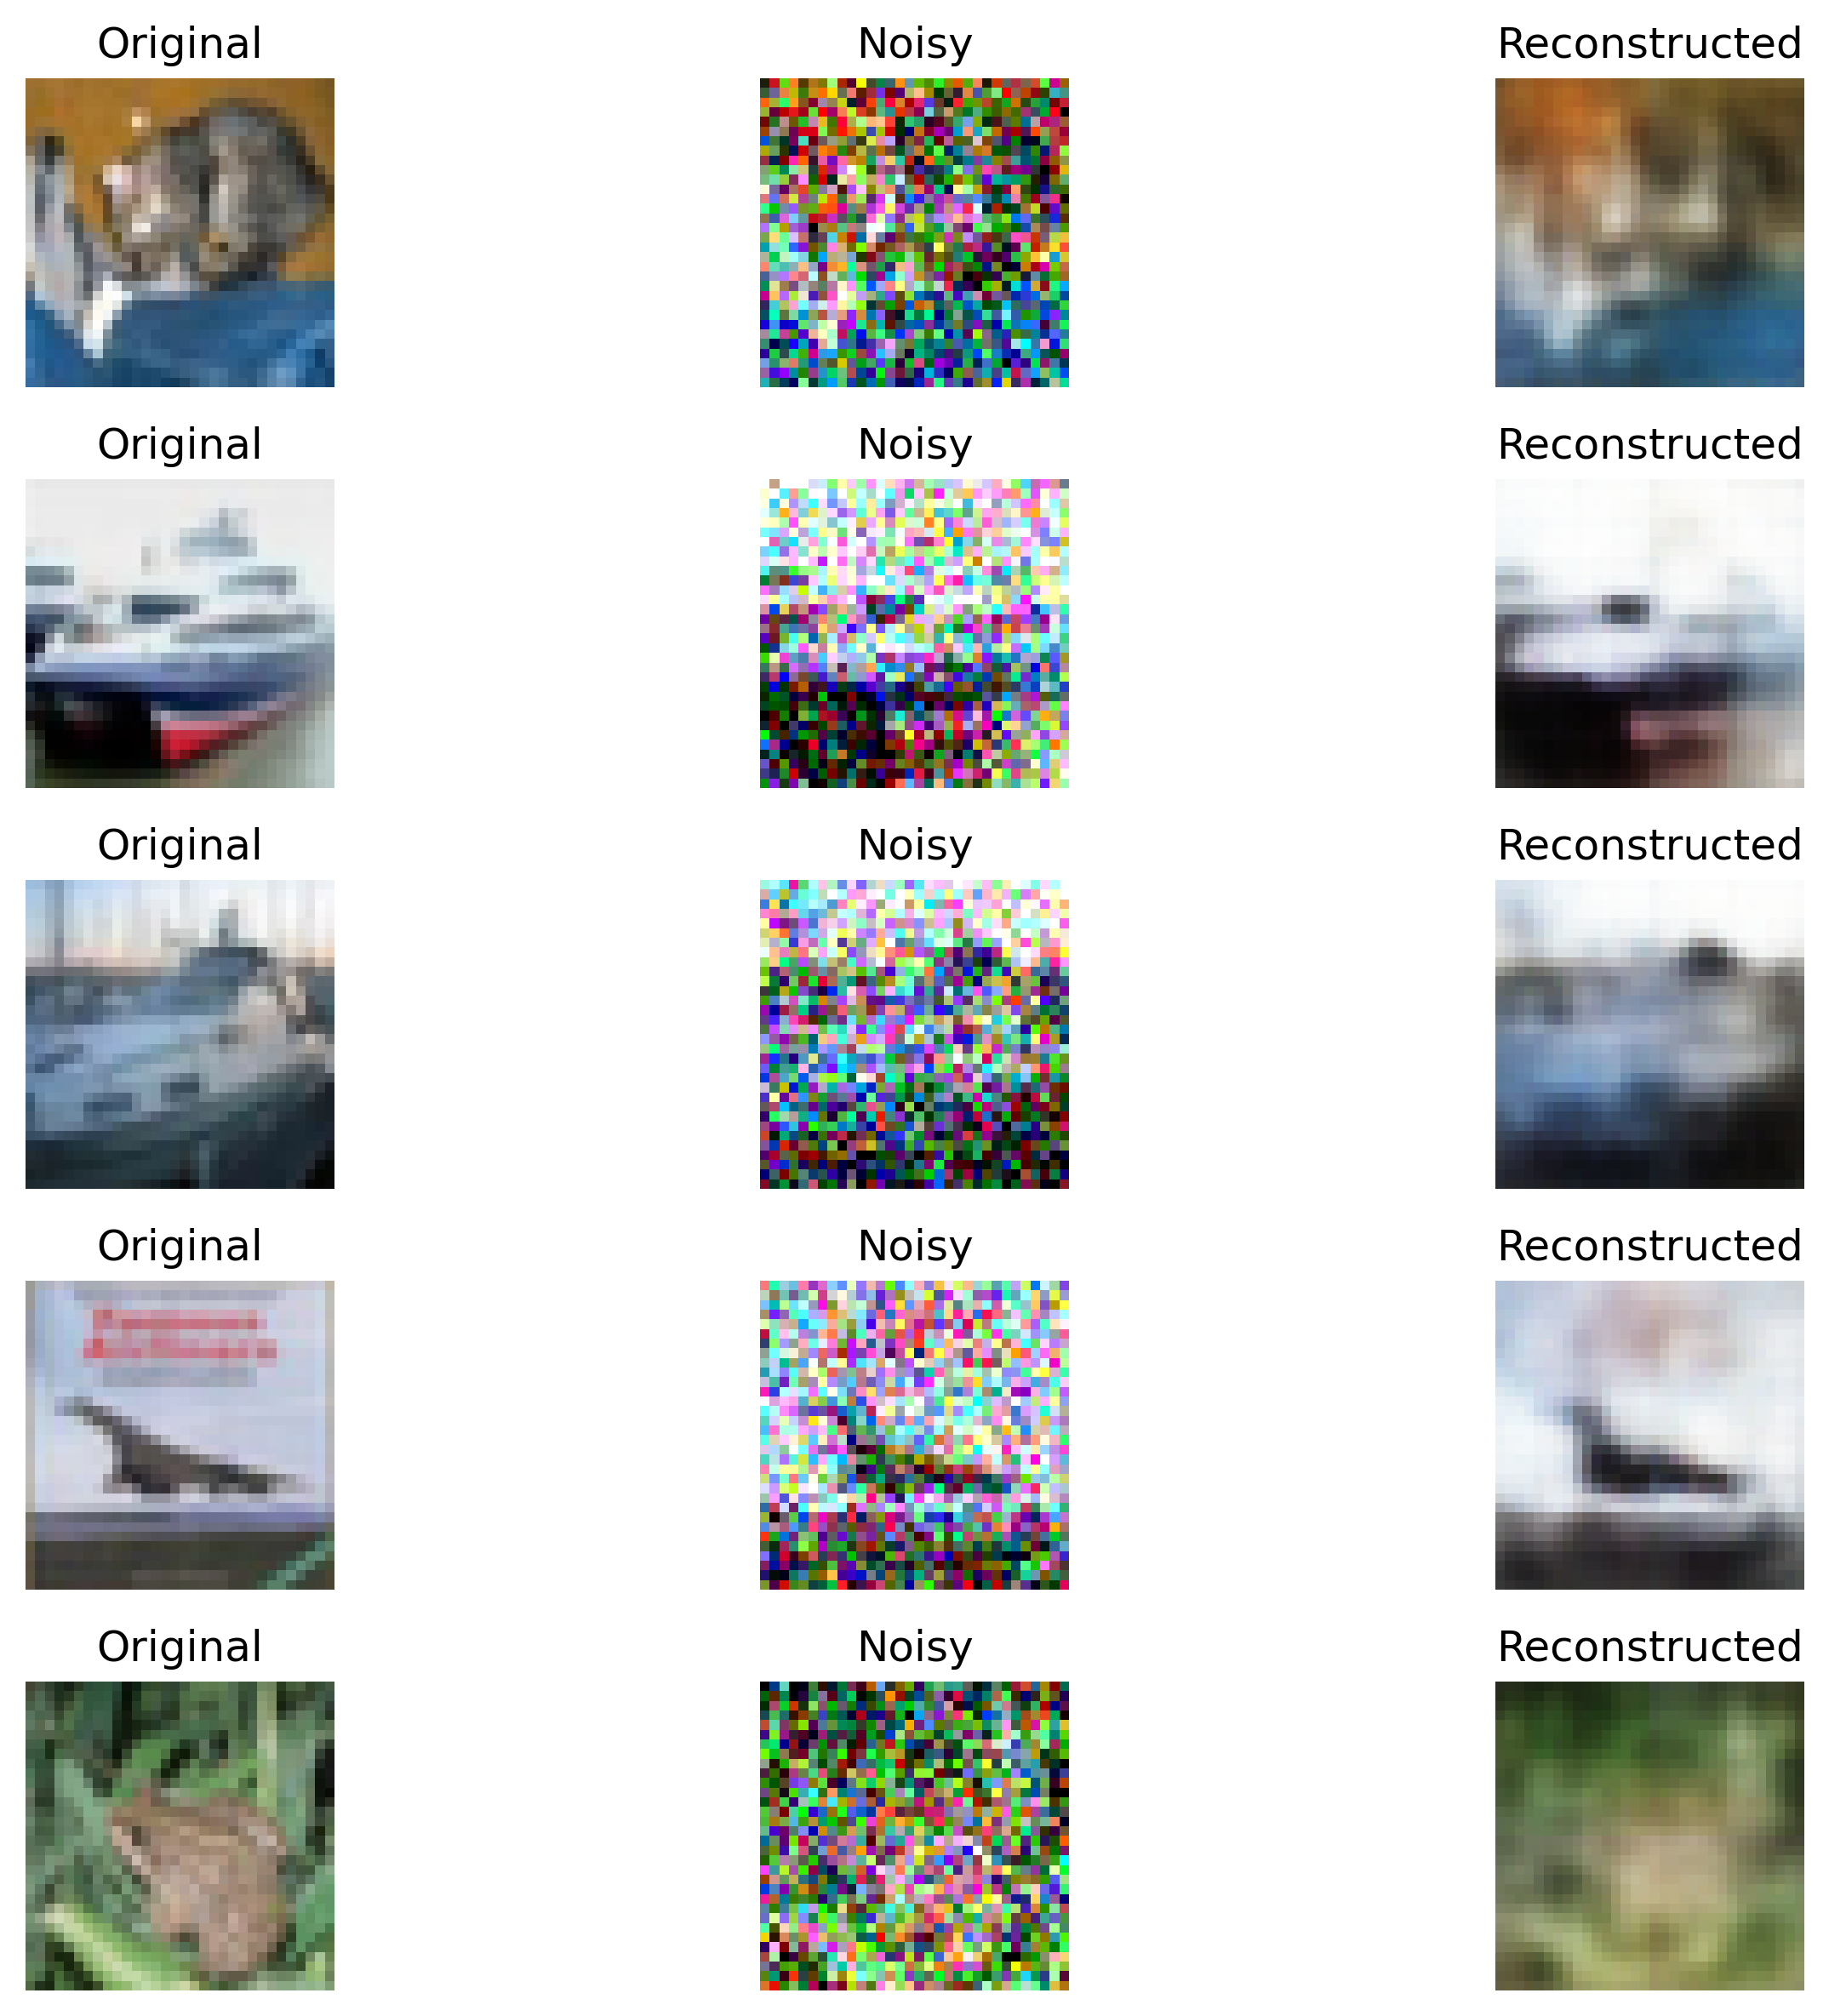

In [9]:
# ----------------------
# Visualize Clean, Noisy, and Reconstructed Images
# ----------------------
def imshow_tensor(img):
    npimg = img.numpy().transpose(1, 2, 0)
    return np.clip(npimg, 0, 1)

model.eval()
dataiter = iter(testloader)
images, _ = next(dataiter)
noisy_images = add_gaussian_noise(images, std=0.3)

with torch.no_grad():
    reconstructed, _ = model(noisy_images.to(device))

fig, axes = plt.subplots(5, 3, figsize=(10, 8), dpi=300)
for i in range(5):
    axes[i, 0].imshow(imshow_tensor(images[i]))
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(imshow_tensor(noisy_images[i]))
    axes[i, 1].set_title("Noisy")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(imshow_tensor(reconstructed.cpu()[i]))
    axes[i, 2].set_title("Reconstructed")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("dae_visualization.png", dpi=300)
plt.show()
